# Integration Test 2

In [19]:
from pynq import PL
PL.reset()

In [20]:
# Use the RFSoC base overlay
from pynq.overlays.base import BaseOverlay
base = BaseOverlay('base.bit')

# ADC Initialization
Use ADC D for this demo. Both mixers bypassed, real data viewed. Sample frequency is 4.9152GHz. Decimator is bypassed.

In [21]:
import xrfdc
# ADC initialization
# Channels
DAC_CHANNEL_B = 0 # 'Channel 0': {'Tile': 224, 'Block': 0}
DAC_CHANNEL_A = 1 # 'Channel 1': {'Tile': 230, 'Block': 0}
ADC_CHANNEL_D = 0 # 'Channel 0': {'Tile': 224, 'Block': 0}
ADC_CHANNEL_C = 1 # 'Channel 1': {'Tile': 224, 'Block': 1}
ADC_CHANNEL_B = 2 # 'Channel 2': {'Tile': 226, 'Block': 0}
ADC_CHANNEL_A = 3 # 'Channel 3': {'Tile': 226, 'Block': 1}
adc_array = [ADC_CHANNEL_D]
adc_char_array = ['D', 'C', 'B', 'A']
sample_scaler = 512
number_samples = int(32768/sample_scaler)  # Between 16 and 32768
decimation_factor = 1 # 2 is default
sample_frequency = 4915.2e6/decimation_factor  # Hz The default sample frequency is 4915.2e6 Hz which is sufficient for our signal
original_adc_settings = base.radio.receiver.channel[ADC_CHANNEL_D].adc_block.MixerSettings
for ADC in adc_array:
    base.radio.receiver.channel[ADC].adc_block.DecimationFactor = decimation_factor
    base.radio.receiver.channel[ADC].adc_block.MixerSettings = {
        'CoarseMixFreq':  xrfdc.COARSE_MIX_BYPASS,
        'EventSource':    xrfdc.EVNT_SRC_TILE,
        'FineMixerScale': xrfdc.MIXER_SCALE_1P0,
        'Freq':           0.0,
        'MixerMode':      xrfdc.MIXER_MODE_R2C,
        'MixerType':      xrfdc.MIXER_TYPE_FINE,
        'PhaseOffset':    0.0
    }
    base.radio.receiver.channel[ADC].adc_block.UpdateEvent(xrfdc.EVENT_MIXER)
print("Original ADC settings:", original_adc_settings)
print("New ADC settings:", base.radio.receiver.channel[ADC].adc_block.MixerSettings)

Original ADC settings: {'Freq': -1228.8, 'PhaseOffset': 0.0, 'EventSource': 2, 'CoarseMixFreq': 0, 'MixerMode': 3, 'FineMixerScale': 1, 'MixerType': 2}
New ADC settings: {'Freq': 0.0, 'PhaseOffset': 0.0, 'EventSource': 2, 'CoarseMixFreq': 0, 'MixerMode': 3, 'FineMixerScale': 1, 'MixerType': 2}


# Initialize PMOD & GPIO
Use one out pin to trigger Lazy Harold to perform one twitch. Drive pin low to start. Use change in state of switchs to start sequence and rgb leds to monitor progress.

In [22]:
from pynq.lib import Pmod_IO
from pynq.lib import AxiGPIO
lazy_harold_ear = Pmod_IO(base.PMODB,2,'out')
yellow_harold = Pmod_IO(base.PMODB,3,'out')
green_harold = Pmod_IO(base.PMODB,6,'out')
# Red is both low, yellow is pin 11 high, green is pin 12 high
# Default to red
yellow_harold.write(0)
green_harold.write(0)
lazy_harold_ear.write(0)    # Drive pin low
switches_ip = base.ip_dict['sws_gpio']
switches = AxiGPIO(switches_ip).channel1

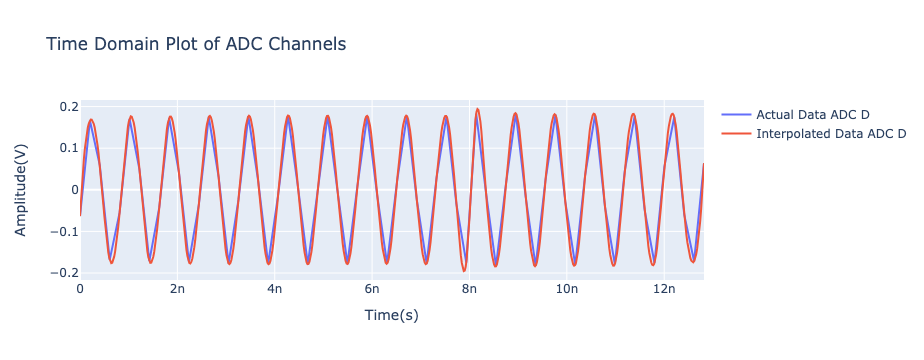

Max amplitude of ADC D : 0.19420300581424252 V.
Max power of ADC D : -7.245181006638121 dBm.


In [23]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from scipy.interpolate import CubicSpline
import numpy as np
# Containers
rx_data = []
rx_real_data = []
raw_data = []
# Create Plotly figure for interpolated ADC data
raw_fig = make_subplots(specs=[[{"secondary_y": False}]])  # Adjust as necessary
# Needed for interpolation
time_data = np.arange(0, number_samples/sample_frequency, 1/sample_frequency)
dense_t = np.linspace(time_data.min(), time_data.max(), len(time_data) * 10)  # Increase density
# Get chunk of data, interpolate it, and create trace for each ADC in adc_array
for index, ADC in enumerate(adc_array):
    rx_data.append(base.radio.receiver.channel[ADC].transfer(number_samples))
    # print("rx_data:", rx_data)
    rx_real_data.append(np.real(rx_data[index]))
    sampled_signal = np.real(rx_data[index])
    cs_real = CubicSpline(time_data, sampled_signal)
    # Raw interpolated data
    raw_data.append(cs_real(dense_t))
    # Add actual data trace
    raw_fig.add_trace(
    go.Scatter(x=time_data, y=sampled_signal, name=f"Actual Data ADC {adc_char_array[ADC]}"),
    secondary_y=False,
    )
    # Add raw interpolated data trace
    raw_fig.add_trace(
    go.Scatter(x=dense_t, y=raw_data[index], name=f"Interpolated Data ADC {adc_char_array[ADC]}"),
    secondary_y=False,
    )
# Update layout of raw ADC data
raw_fig.update_layout(
title=f"Time Domain Plot of ADC Channels",
xaxis_title="Time(s)",
yaxis_title="Amplitude(V)",
)
# Show raw ADC data
raw_fig.show()
# Calculate max power of each ADC channel
for index, ADC in enumerate(adc_array):
    max_amplitude = raw_data[index][np.argmax(raw_data[index])]
    max_power = 10*np.log10((np.square(max_amplitude/np.sqrt(2))/100)/.001)
    print("Max amplitude of ADC", adc_char_array[ADC], ":", max_amplitude, "V.")
    print("Max power of ADC", adc_char_array[ADC], ":", max_power, "dBm.")

# Perform Measure and Twitch Sequence
UI controls step size and range of sweep. Test [-90, 90] degrees at step size of .9 degrees for this demo.
Expecting 201 steps and 201 corresponding, calculated power values. Expecting max power of -11.87220293 dBm. Successful if max power is > -13.01029996 dBm.

In [5]:
import time
import matplotlib.pyplot as plt
lazy_harold_ear.write(0)    # Drive pin low
yellow_harold.write(0)
green_harold.write(0)
switch_state = switches.read()
# Test system variables
message = 1
LH_step_size = .9
start_angle = -90 # (degrees)
sweep_degrees = 180 # Choose MUST BE MULTIPLE OF .9 (degrees)
rx_data = []
power_data = []
raw_data = []
sampled_signal = []
# Needed for interpolation
time_data = np.arange(0, number_samples/sample_frequency, 1/sample_frequency)
dense_t = np.linspace(time_data.min(), time_data.max(), len(time_data) * 10)  # Increase density
# Wait for switch to be switched
print("System ready, flick any switch to begin test sequence...")
while switches.read() == switch_state:
    time.sleep(.1)
if (int(sweep_degrees%LH_step_size)) != 0:
    print("Invalid sweep_degrees. Choose value divisible by", LH_step_size)
number_of_measurements = (sweep_degrees / LH_step_size) + 1
end_angle = start_angle + sweep_degrees # (degrees)
actual_radians = sweep_degrees*(np.pi/180)
print("Sweeping", sweep_degrees, "degrees to generate radiation pattern using", int(number_of_measurements), "measurements recorded between", start_angle, "degrees and", end_angle, "degrees every", LH_step_size, "degrees...")
for measurement in range(0, int(number_of_measurements)):
    # Take measurement
    rx_data.append(base.radio.receiver.channel[adc_array[0]].transfer(number_samples))
    # Interpolate data
    sampled_signal.append(np.real(rx_data[measurement]))
    cs_real = CubicSpline(time_data, sampled_signal[measurement])
    raw_data = (cs_real(dense_t))
    # Calculate max power of sample chunk
    power_chunk = 10*np.log10((np.square(raw_data[np.argmax(raw_data)]/np.sqrt(2))/100)/.001)
    power_data.append(power_chunk)
    # Turn on appropriate LED
    if power_chunk < -10 and power_chunk > -18:
        green_harold.write(0)
        yellow_harold.write(1)
    elif power_chunk > -10:
        yellow_harold.write(0)
        green_harold.write(1)
    else:
        green_harold.write(0)
        yellow_harold.write(0)
    # Tell LH measurement is complete
    if measurement != (number_of_measurements - 1):
        lazy_harold_ear.write(message)
        if message == 1:
            message = 0
        else:
            message = 1
        # Give LH time to complete a twitch
        time.sleep(1)
switch_state = switches.read()
peak_index = np.argmax(power_data)
peak_power = power_data[peak_index]
# Normalize data
for i,j in enumerate(power_data): power_data[i] -= peak_power
# Lobe finding
main_lobe_index = np.argmax(power_data)
main_lobe_power = power_data[main_lobe_index]
main_lobe_angle = start_angle + (main_lobe_index*LH_step_size)
neg_side_lobe_index = np.argmax(power_data[(int(10/LH_step_size)):(int(60/LH_step_size))])+(int(10/LH_step_size))
neg_side_lobe_power = power_data[neg_side_lobe_index]
neg_side_lobe_angle = start_angle + (neg_side_lobe_index*LH_step_size)
neg_side_null_index = np.argmin(power_data[neg_side_lobe_index:main_lobe_index])+neg_side_lobe_index
neg_side_null_power = power_data[neg_side_null_index]
neg_side_null_angle = start_angle + (neg_side_null_index*LH_step_size)
pos_side_lobe_index = np.argmax(power_data[(int(131/LH_step_size)):(int(171/LH_step_size))])+(int(131/LH_step_size))
pos_side_lobe_power = power_data[pos_side_lobe_index]
pos_side_lobe_angle = start_angle + (pos_side_lobe_index*LH_step_size)
pos_side_null_index = np.argmin(power_data[main_lobe_index:pos_side_lobe_index])+main_lobe_index
pos_side_null_power = power_data[pos_side_null_index]
pos_side_null_angle = start_angle + (pos_side_null_index*LH_step_size)
# Plotting
angles = np.linspace(-np.pi/2, (-np.pi/2)+actual_radians, int(number_of_measurements))
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(angles, power_data) # MAKE SURE TO USE RADIAN FOR POLAR
ax.plot(angles[main_lobe_index], main_lobe_power, 'g^')
ax.plot(angles[neg_side_lobe_index], neg_side_lobe_power, 'y*')
ax.plot(angles[pos_side_lobe_index], pos_side_lobe_power, 'y*')
ax.plot(angles[neg_side_null_index], neg_side_null_power, 'r*')
ax.plot(angles[pos_side_null_index], pos_side_null_power, 'r*')
ax.set_theta_zero_location('N') # make 0 degrees point up
ax.set_theta_direction(-1) # increase clockwise
ax.set_rlabel_position(55)  # Move grid labels away from other labels
plt.show()
# Stats
print("Peak power:", peak_power, "dBm")
print("Main lobe max power:", main_lobe_power, "dBm detected at:", main_lobe_angle, "degrees")
print("Left side lobe max power:", neg_side_lobe_power, "dBm detected at:", neg_side_lobe_angle, "degrees")
print("Right lobe max power:", pos_side_lobe_power, "dBm detected at:", pos_side_lobe_angle, "degrees")
print("Left side null power:", neg_side_null_power, "dBm detected at:", neg_side_null_angle, "degrees")
print("Right side null power:", pos_side_null_power, "dBm detected at:", pos_side_null_angle, "degrees")

NameError: name 'np' is not defined

In [ ]:

received_data = []
switch_state = switches.read()
array = 1
# message = 1
# Needed for interpolation
time_data = np.arange(0, number_samples/sample_frequency, 1/sample_frequency)
dense_t = np.linspace(time_data.min(), time_data.max(), len(time_data) * 10)  # Increase density
print("Phased array scanning... Flip any switch to stop scanning and view real time data.")
while switches.read() == switch_state:
    received_data = base.radio.receiver.channel[adc_array[0]].transfer(number_samples)
    # Interpolate data
    sampled_signal = np.real(received_data)
    cs_real = CubicSpline(time_data, sampled_signal)
    raw_data = (cs_real(dense_t))
    # Calculate max power of sample chunk
    power_chunk = 10*np.log10((np.square(raw_data[np.argmax(raw_data)]/np.sqrt(2))/100)/.001)
    if array == 1:
        # Turn on appropriate LED
        if power_chunk <= -10 and power_chunk > -18:
            green_harold.write(0)
            yellow_harold.write(1)
            # print("Yellow")
        elif power_chunk > -10:
            yellow_harold.write(0)
            green_harold.write(1)
            # print("Green")
        else:
            green_harold.write(0)
            yellow_harold.write(0)
            # print("Red")
    else:
        if power_chunk < -25 and power_chunk > -30:
            green_harold.write(0)
            yellow_harold.write(1)
            # print("Yellow")
        elif power_chunk > -25:
            yellow_harold.write(0)
            green_harold.write(1)
            # print("Green")
        else:
            green_harold.write(0)
            yellow_harold.write(0)
            # print("Red")
    time.sleep(.1)
# Create Plotly figure for interpolated ADC data
raw_fig = make_subplots(specs=[[{"secondary_y": False}]])  # Adjust as necessary
# Add raw interpolated data trace
raw_fig.add_trace(
go.Scatter(x=dense_t, y=raw_data, name=f"Interpolated Data ADC {adc_char_array[0]}"),
secondary_y=False,
)
# Update layout of raw ADC data
raw_fig.update_layout(
title=f"Time Domain Plot of ADC Channels",
xaxis_title="Time(s)",
yaxis_title="Amplitude(V)",
)
raw_fig.show()
print("Power:", power_chunk, "dBm")

Phased array scanning... Flip any switch to stop scanning and view real time data.
